# Prediction of Breast Cancer with Machine Learning 

## At the begining, import the useful packages and set up format for the plots

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import seaborn as sns
# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")


c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## 1. Exploratory Analysis
### Load Breast Cancer Database

In [3]:
from sklearn.datasets import load_breast_cancer


In [4]:
bunch = load_breast_cancer()
bunch.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [5]:
print(bunch.target_names)


['malignant' 'benign']


In [6]:
print(bunch.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


#### The description of the breast cancer data set

In [7]:
print(bunch.DESCR)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

## 2. Data Visualization and Pre-processing

In [8]:
bunch = load_breast_cancer()
df = pd.DataFrame(bunch.data,columns=bunch.feature_names)
df['diagnosis'] = bunch.target # Whether the patients have Malignant(target=0) or Benign(target =1)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Let's take a look at the number of Benign and Maglinant cases from the dataset. From the output shown below, majority of the cases are benign (1).

In [9]:
print(df.groupby('diagnosis').size())

diagnosis
0    212
1    357
dtype: int64


In [43]:
df.columns[1]

'mean texture'

### Next, we visualise the data using density plots to get a sense of the data distribution(Kernel density estimaton). The kernel density estimate may be less familiar, but it can be a useful tool for plotting the shape of a distribution. Like the histogram, the KDE plots encodes the density of observations on one axis with height along the other axis: From the outputs below, you can see the data shows a general gaussian distribution.

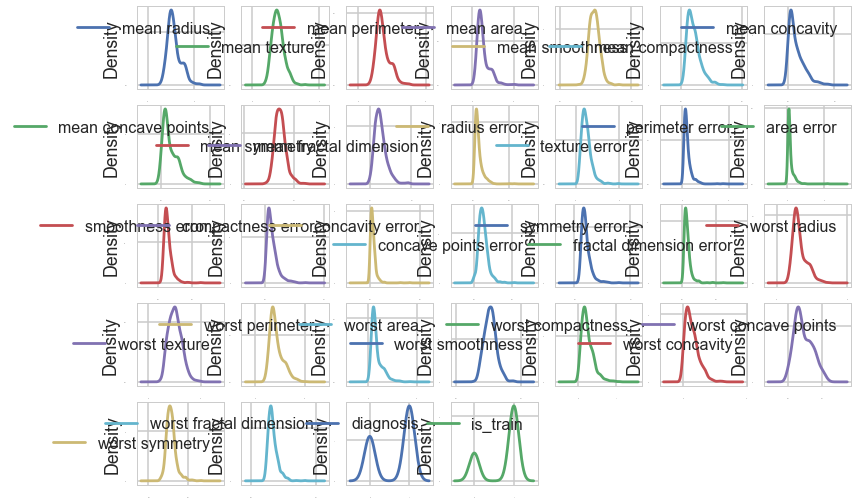

In [59]:
df.plot(kind='density', subplots=True, layout=(5,7), sharex=False, legend=True, fontsize=1)
#plt.legend(loc=1)


plt.show()

In [11]:
### It is good to check the correlations between the attributes. From the output graph below, The red around the diagonal suggests that attributes are correlated with each other. The yellow and green patches suggest some moderate correlation and the blue boxes show negative correlations.

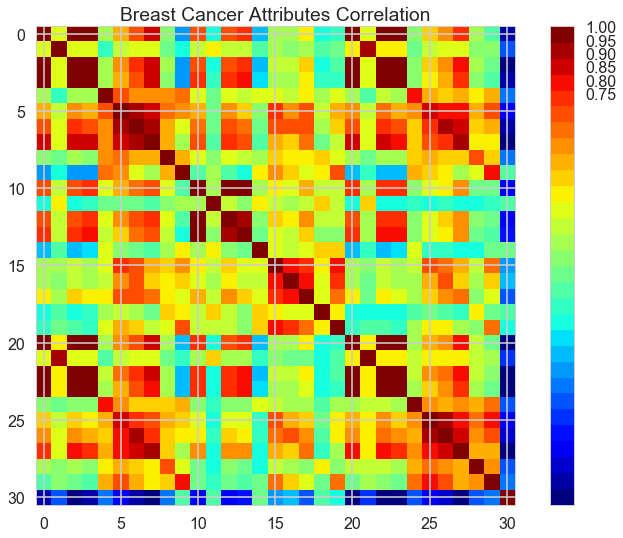

In [12]:
from matplotlib import cm as cm

fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax1.imshow(df.corr(), interpolation="none", cmap=cmap)
ax1.grid(True)
plt.title('Breast Cancer Attributes Correlation')
# Add colorbar, make sure to specify tick locations to match desired ticklabels
fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
plt.show()

## 3. Baseline Algorithm Checking

### From the dataset, we will analysis and build a model to predict if a given set of symptoms lead to breast cancer. This is a binary classification problem, and a few algorithms are appropriate for use. Since we do not know which one will perform the best at the point, we will do a quick test on the few appropriate algorithms with default setting to get an early indication of how each of them perform. We will use 10 fold cross validation for each testing.

### The following non-linear algorithms will be used, namely: Classification and Regression Trees (CART), Linear Support Vector Machines (SVM), Gaussian Naive Bayes (NB) and k-Nearest Neighbors (KNN).

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

In [14]:
models_list = []
models_list.append(('CART', DecisionTreeClassifier()))
models_list.append(('SVM', SVC())) 
models_list.append(('NB', GaussianNB()))
models_list.append(('KNN', KNeighborsClassifier()))

In [15]:
Y = df['diagnosis'].values
X = df.drop('diagnosis', axis=1).values

X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.20, random_state=21)
print (X_train.shape, Y_train.shape)
print (X_test.shape, Y_test.shape)

(455, 30) (455,)
(114, 30) (114,)


### The function cross_val_predict has a similar interface to cross_val_score, but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. Only cross-validation strategies that assign all elements to a test set exactly once can be used (otherwise, an exception is raised).

In [60]:
num_folds =5
results = []
names = []
from sklearn.model_selection import cross_val_predict
for name, model in models_list:
    kfold = KFold(n_splits=num_folds, random_state=123)
    start = time.time()
    #cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    #cv_results = cross_val_predict(model, X_train, Y_train, cv=kfold)
    clf =model.fit(X_train,Y_train)
    cv_results = cross_val_score(clf, X_test, Y_test, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

CART: 0.939130 (0.044339) (run time: 0.017904)
SVM: 0.657708 (0.070245) (run time: 0.023587)
NB: 0.921344 (0.050438) (run time: 0.006720)
KNN: 0.886166 (0.070369) (run time: 0.008835)


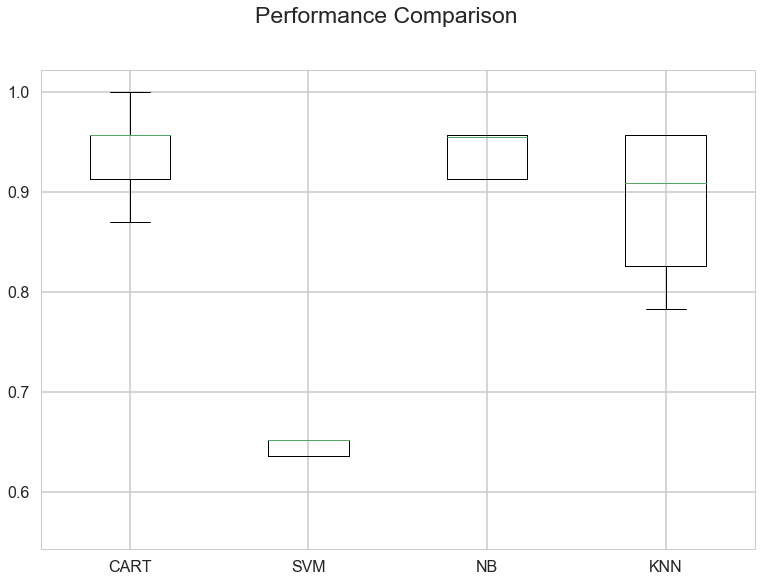

In [61]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [64]:
num_folds = 10
results = []
names = []

for name, model in models_list:
    kfold = KFold(n_splits=num_folds, random_state=123)
    start = time.time()
    #cv_results = cross_val_score(model, X_test, Y_test, cv=kfold, scoring='accuracy')
    clf =model.fit(X_train,Y_train)
    cv_results = cross_val_score(clf, X_test, Y_test, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

CART: 0.903788 (0.083130) (run time: 0.026122)
SVM: 0.655303 (0.108957) (run time: 0.034442)
NB: 0.930303 (0.073434) (run time: 0.011526)
KNN: 0.894697 (0.085405) (run time: 0.018795)


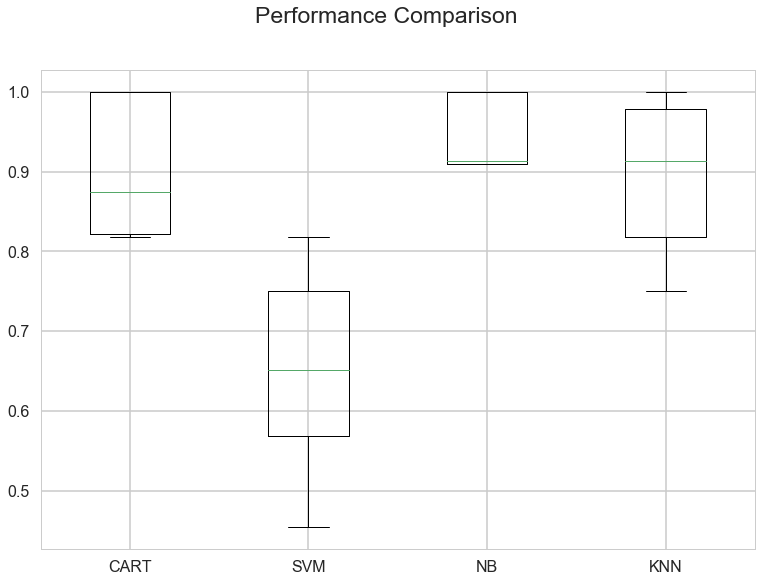

In [65]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### From the initial run, it looks like GaussianNB, KNN and CART performed the best given the dataset (all above 92% mean accuracy). Support Vector Machine has a surprisingly bad performance here. However, if we standardise the input dataset, it's performance should improve.

## 4. Evaluation of the Algorithm with Standardised Data

### The performance of the few machine learning algorithm could be improved if a standardised dataset is being used. The improvement is likely for all the models. I will use pipelines that standardize the data and build the model for each fold in the cross-validation test harness. That way we can get a fair estimation of how each model with standardized data might perform on unseen data.

In [74]:
import warnings

# Standardize the dataset
pipelines = []

pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
                                                                        DecisionTreeClassifier())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC( ))])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',
                                                                      GaussianNB())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
                                                                       KNeighborsClassifier())])))
results = []
names = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kfold = KFold(n_splits=num_folds, random_state=123)
    for name, model in pipelines:
        start = time.time()
        #model =model.fit(X_train,Y_train)
        #cv_results = cross_val_score(model, X_test, Y_test, cv=kfold, scoring='accuracy')
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
        end = time.time()
        results.append(cv_results)
        names.append(name)
        print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

ScaledCART: 0.923140 (0.034533) (run time: 0.074612)
ScaledSVM: 0.964879 (0.038621) (run time: 0.059169)
ScaledNB: 0.931932 (0.038625) (run time: 0.018939)
ScaledKNN: 0.958357 (0.038595) (run time: 0.031357)


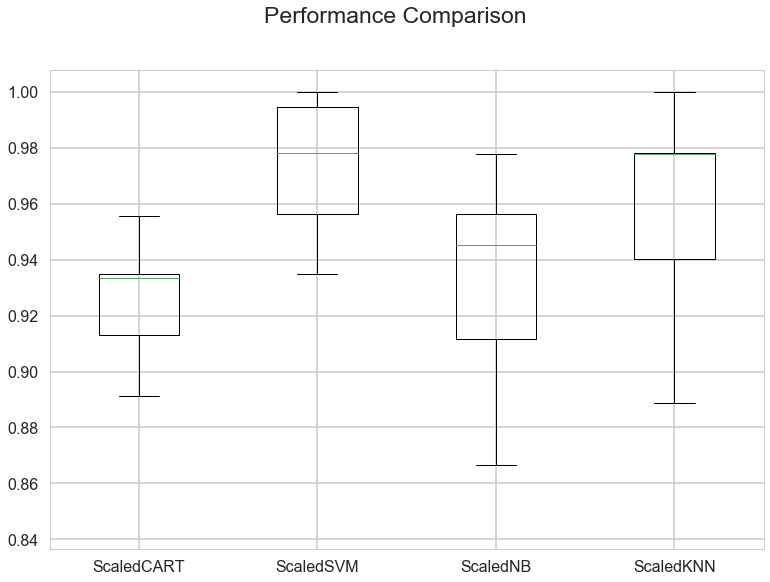

In [75]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Algorithm Tuning - Tuning SVM

#### We will focus on SVM for the algorithm tuning. We can tune two key parameter of the SVM algorithm - the value of C and the type of kernel. The default C for SVM is 1.0 and the kernel is Radial Basis Function (RBF). We will use the grid search method using 10-fold cross-validation with a standardized copy of the sample training dataset. We will try over a combination of C values and the following kernel types 'linear', 'poly', 'rbf' and 'sigmoid

In [24]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.969231 using {'C': 2.0, 'kernel': 'rbf'}
0.964835 (0.026196) with: {'C': 0.1, 'kernel': 'linear'}
0.826374 (0.058723) with: {'C': 0.1, 'kernel': 'poly'}
0.940659 (0.038201) with: {'C': 0.1, 'kernel': 'rbf'}
0.949451 (0.032769) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.962637 (0.029474) with: {'C': 0.3, 'kernel': 'linear'}
0.868132 (0.051148) with: {'C': 0.3, 'kernel': 'poly'}
0.958242 (0.031970) with: {'C': 0.3, 'kernel': 'rbf'}
0.953846 (0.043579) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.956044 (0.030933) with: {'C': 0.5, 'kernel': 'linear'}
0.881319 (0.050677) with: {'C': 0.5, 'kernel': 'poly'}
0.964835 (0.029906) with: {'C': 0.5, 'kernel': 'rbf'}
0.953846 (0.026785) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.953846 (0.031587) with: {'C': 0.7, 'kernel': 'linear'}
0.885714 (0.038199) with: {'C': 0.7, 'kernel': 'poly'}
0.967033 (0.037271) with: {'C': 0.7, 'kernel': 'rbf'}
0.953846 (0.028513) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.951648 (0.028834) with: {'C': 0.9, 'kernel': 'linear'

#### We can see the most accurate configuration was SVM with an RBF kernel and C=2.0, with the accuracy of 96.92%.

## Application of SVM on Dataset

In [25]:
# prepare the model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
model = SVC(C=2.0, kernel='rbf')
start = time.time()
model.fit(X_train_scaled, Y_train)
end = time.time()
print( "Run Time: %f" % (end-start))

Run Time: 0.005123


In [26]:
# estimate accuracy on test dataset
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_test_scaled = scaler.transform(X_test)
predictions = model.predict(X_test_scaled)

In [27]:
print("Accuracy score %f" % accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions))

Accuracy score 0.991228
             precision    recall  f1-score   support

          0       0.97      1.00      0.99        39
          1       1.00      0.99      0.99        75

avg / total       0.99      0.99      0.99       114



In [78]:
print(confusion_matrix(Y_test, predictions))


[[39  0]
 [ 1 74]]


#### We can see that we achieve an accuracy of 99.1% on the held-out test dataset. From the confusion matrix, there is only 1 case of mis-classification. The performance of this algorithm is expected to be high given the symptoms for breast cancer should exchibit certain clear patterns.

## Random Forest Analysis

###  Ranking the importance of the classifications

In [29]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis,is_train
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,True
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,True
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,True
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,False
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,True


In [30]:
train, test = df[df['is_train']==True], df[df['is_train']==False]

                        importance
feature                           
mean concave points          0.305
mean concavity               0.228
mean area                    0.135
mean perimeter               0.109
mean texture                 0.057
mean radius                  0.056
mean compactness             0.051
mean smoothness              0.026
mean symmetry                0.020
mean fractal dimension       0.013


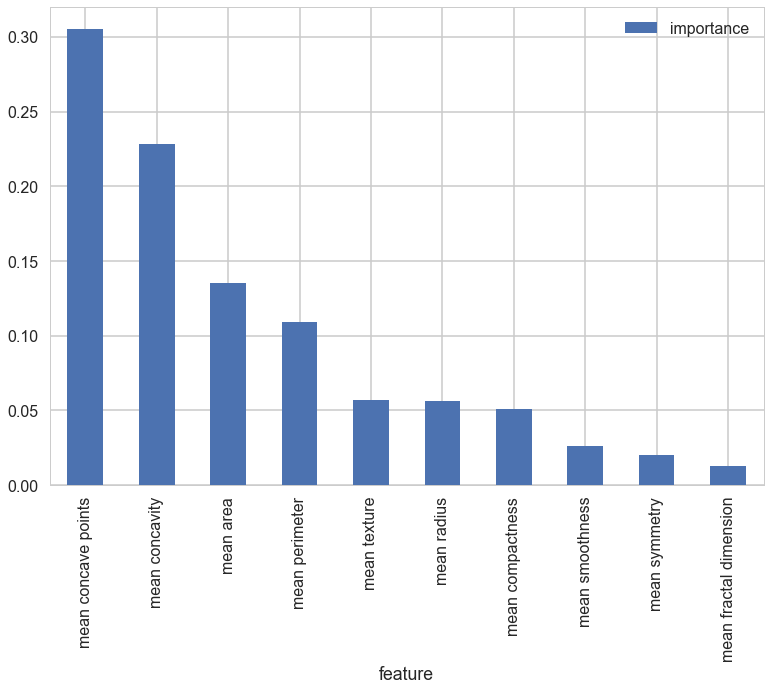

In [31]:
y = pd.factorize(train['diagnosis'])[0]
features = df.columns[:10]
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=2, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(train[features], y)
importances = pd.DataFrame({'feature':features,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
 
print (importances)
importances.plot.bar()
plt.show()

### Confusion Matrix

In [32]:
preds = bunch.target_names[clf.predict(test[features])]
pd.crosstab(test['diagnosis'], preds, rownames=['Actual Diagnosis'], colnames=['Predicted Dignosis'])


Predicted Dignosis,benign,malignant
Actual Diagnosis,,
0,4,52
1,95,3


### The columns are the diagnosis we predicted for the test data and the rows are the actual species for the test data. 

### View a list of the features and their importance scores


In [33]:
list(zip(train[features], clf.feature_importances_))

[('mean radius', 0.056306144919601134),
 ('mean texture', 0.057265088107867568),
 ('mean perimeter', 0.1086242140078332),
 ('mean area', 0.13511151843307082),
 ('mean smoothness', 0.026140580013836078),
 ('mean compactness', 0.050575423603400824),
 ('mean concavity', 0.22757359381589773),
 ('mean concave points', 0.30545914754484477),
 ('mean symmetry', 0.020118473955737466),
 ('mean fractal dimension', 0.012825815597910467)]